卷积神经网络（LeNet）  
本节将介绍LeNet，它是最早发布的卷积神经网络之一，因其在计算机视觉任务中的高效性能而受到广泛关注  
当时，LeNet取得了与支持向量机（support vector machines）性能相媲美的成果，成为监督学习的主流方法。   
LeNet被广泛用于自动取款机（ATM）机中，帮助识别处理支票的数字。

总体来看，LeNet（LeNet-5）由两个部分组成：

    卷积编码器：由两个卷积层组成;

    全连接层密集块：由三个全连接层组成。


![alt text](image.png)

每个卷积块中的基本单元是一个卷积层、一个sigmoid激活函数和平均汇聚层  
卷积层将输入映射到多个二维特征输出，通常同时增加通道的数量。  
第一卷积层有6个输出通道，而第二个卷积层有16个输出通道  
2*2 pooling通过空间下采样将维数减少4倍  


为了将卷积块的输出传递给稠密块，我们必须在小批量中展平每个样本。  
换言之，我们将这个四维输入转换成全连接层所期望的二维输入。  
这里的二维表示的第一个维度索引小批量中的样本，第二个维度给出每个样本的平面向量表示。  
LeNet的稠密块有三个全连接层，分别有120、84和10个输出。  
因为我们在执行分类任务，所以输出层的10维对应于最后输出结果的数量。

用深度学习框架实现此类模型非常简单  
对原始模型做了一点小改动，去掉了最后一层的高斯激活

In [135]:
import torch
from torch import nn
from d2l import torch as d2l

net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),#将多维数据转换为一维
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))


下面，我们将一个大小为28*28的单通道（黑白）图像通过LeNet。  
通过在每一层打印输出的形状，我们可以检查模型，以确保其操作与我们期望的一致  
![alt text](image-1.png)

In [136]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)


Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


在整个卷积块中，与上一层相比，每一层特征的高度和宽度都减小了  
第二个卷积层没有填充，因此高度和宽度都减少了4个像素。   
随着层叠的上升，通道的数量从输入时的1个，增加到第一个卷积层之后的6个，再到第二个卷积层之后的16个。   
同时，每个汇聚层的高度和宽度都减半。  
最后，每个全连接层减少维数，最终输出一个维数与结果分类数相匹配的输出。

模型训练  
看看LeNet在Fashion-MNIST数据集上的表现  


In [137]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

虽然卷积神经网络的参数较少，但与深度的多层感知机相比，它们的计算成本仍然很高，因为每个参数都参与更多的乘法。   
通过使用GPU，可以用它加快训练。  
为了进行评估，我们需要对 3.6节中描述的evaluate_accuracy函数进行轻微的修改。   
由于完整的数据集位于内存中，因此在模型使用GPU计算数据集之前，我们需要将其复制到显存中。

<pre>net.parameters()
返回模型net中所有可训练参数（如权重、偏置）的生成器（Generator）

iter(...)
将生成器转换为迭代器（Iterator），使得我们可以使用next()获取第一个元素。

next(iter(...))
从迭代器中取出第一个参数（例如net的第一个卷积层的权重）。如果模型为空（无参数），会抛出StopIteration异常，但实际中模型至少有一个参数。

.device
每个PyTorch张量（Tensor）都有device属性，表示其所在的计算设备。例如：
    cpu：CPU设备
    cuda:0：第一个GPU设备
    cuda:1：第二个GPU设备（如果有多个GPU）



In [138]:
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]


为了使用GPU，我们还需要一点小改动。  
与 3.6节中定义的train_epoch_ch3不同，在进行正向和反向传播之前，我们需要将每一小批量数据移动到我们指定的设备（例如GPU）上。

如下所示，训练函数train_ch6也类似于 3.6节中定义的train_ch3。  
由于我们将实现多层神经网络，因此我们将主要使用高级API。  
以下训练函数假定从高级API创建的模型作为输入，并进行相应的优化。  
我们使用在 4.8.2.2节中介绍的Xavier随机初始化模型参数。  
与全连接层一样，我们使用交叉熵损失函数和小批量随机梯度下降。

In [139]:
#@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr,weight_decay=5e-4)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['test loss','train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (None,train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        test_loss=0.0
        test_num=0
        with torch.no_grad():
            for (X, y) in test_iter:
                X, y = X.to(device), y.to(device)
                y_hat = net(X)
                test_loss += loss(y_hat, y)
                test_num+=1
            test_loss=test_loss/(float)(test_num)
            animator.add(epoch + 1, (test_loss.to('cpu'),None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')


loss 0.440, train acc 0.838, test acc 0.823
47003.5 examples/sec on cuda:0


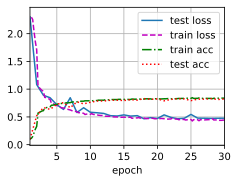

In [140]:
lr, num_epochs = 0.8, 30
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())
